In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
dataset = pd.read_csv('creditcard.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'creditcard.csv'

In [ ]:
sc = StandardScaler()
dataset['Time']=sc.fit_transform(dataset['Time'].values.reshape(-1,1))
dataset['Amount']=sc.fit_transform(dataset['Amount'].values.reshape(-1,1))

In [4]:
raw_data=dataset.values

In [5]:
labels=raw_data[:,-1]
data=raw_data[:,0:-1]

In [6]:
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.2)

In [7]:
min_val=tf.reduce_min(train_data)
max_val=tf.reduce_max(train_data)

train_data=(train_data - min_val)/(max_val - min_val)
test_data=(test_data - min_val)/(max_val - min_val)

train_labels=train_labels.astype(bool)
test_labels=test_labels.astype(bool)

In [8]:
normal_train_data = train_data[~train_labels]
normal_test_data=test_data[~test_labels]

fraud_train_data=train_data[train_labels]
fraud_test_data=test_data[test_labels]

In [9]:
nb_epoch=10
batch_size=64
input_dim=normal_train_data.shape[1]
encoding_dim=14
hidden_dim1 = int(encoding_dim / 2)
hidden_dim2 = 4
learning_rate = 1e-7

In [10]:
#input layer
input_layer = tf.keras.layers.Input(shape=(input_dim,))

#Encoder
encoder = tf.keras.layers.Dense(encoding_dim,activation="tanh",activity_regularizer = tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim1,activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim2,activation=tf.nn.leaky_relu)(encoder)

#Decoder
decoder = tf.keras.layers.Dense(hidden_dim1,activation='relu')(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim,activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim,activation='tanh')(decoder)

#Autoencoder
autoencoder = tf.keras.Model(inputs = input_layer,outputs = decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0     

In [11]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",mode='min',monitor='val_loss',verbose=2,save_best_only=True)
#Define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.0001,
                patience=10,
                verbose=11,
                mode='min',
                restore_best_weights=True
)

In [12]:
autoencoder.compile(metrics=['accuracy'],loss= 'mean_squared_error',optimizer='adam')

In [13]:
history = autoencoder.fit(normal_train_data,normal_train_data,epochs = nb_epoch,
                         batch_size = batch_size,shuffle = True,
                         validation_data = (test_data,test_data),
                         verbose=1,
                         callbacks = [cp,early_stop]).history

Epoch 1/10
3554/3554 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.0593
Epoch 1: val_loss improved from inf to 0.00002, saving model to autoencoder_fraud.h5
3554/3554 [==============================] - 23s 5ms/step - loss: 0.0053 - accuracy: 0.0593 - val_loss: 1.9977e-05 - val_accuracy: 0.0610
Epoch 2/10
  13/3554 [..............................] - ETA: 15s - loss: 1.9952e-05 - accuracy: 0.0457

C:\Users\mohammedaatif\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3545/3554 [============================>.] - ETA: 0s - loss: 1.9334e-05 - accuracy: 0.0626
Epoch 2: val_loss did not improve from 0.00002
3554/3554 [==============================] - 18s 5ms/step - loss: 1.9329e-05 - accuracy: 0.0627 - val_loss: 1.9981e-05 - val_accuracy: 0.0675
Epoch 3/10
3553/3554 [============================>.] - ETA: 0s - loss: 1.9451e-05 - accuracy: 0.0626
Epoch 3: val_loss did not improve from 0.00002
3554/3554 [==============================] - 18s 5ms/step - loss: 1.9454e-05 - accuracy: 0.0626 - val_loss: 2.0479e-05 - val_accuracy: 0.0287
Epoch 4/10
3554/3554 [==============================] - ETA: 0s - loss: 1.9537e-05 - accuracy: 0.0621
Epoch 4: val_loss did not improve from 0.00002
3554/3554 [==============================] - 18s 5ms/step - loss: 1.9537e-05 - accuracy: 0.0621 - val_loss: 2.0234e-05 - val_accuracy: 0.0337
Epoch 5/10
3544/3554 [============================>.] - ETA: 0s - loss: 1.9568e-05 - accuracy: 0.0592
Epoch 5: val_loss did not improve fr

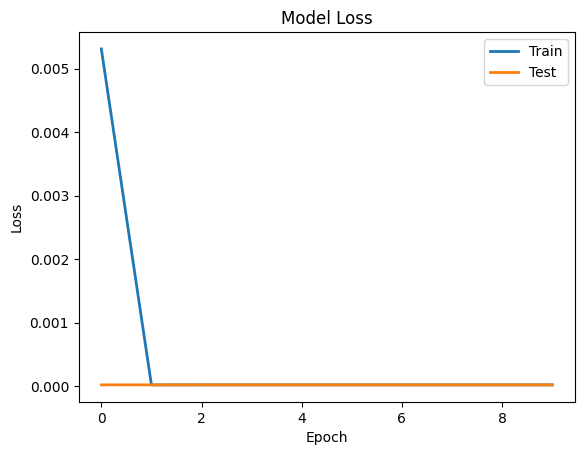

In [14]:
plt.plot(history['loss'],linewidth = 2,label = 'Train')
plt.plot(history['val_loss'],linewidth = 2,label = 'Test')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

#plt.ylim(ymin=0.70,ymax=1)

plt.show()